# Import and visualiza the data

In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
data = pd.read_csv('train.csv')

In [24]:
data.head()

,AT,V,AP,RH,PE
0,29.07,72.51,1009.24,58.38,449.371855
1,32.38,67.17,1006.97,60.04,450.861043
2,19.29,67.71,1007.94,63.71,460.894029
3,16.45,41.48,1016.64,45.21,467.577314
4,21.43,46.97,1013.94,61.25,469.805723


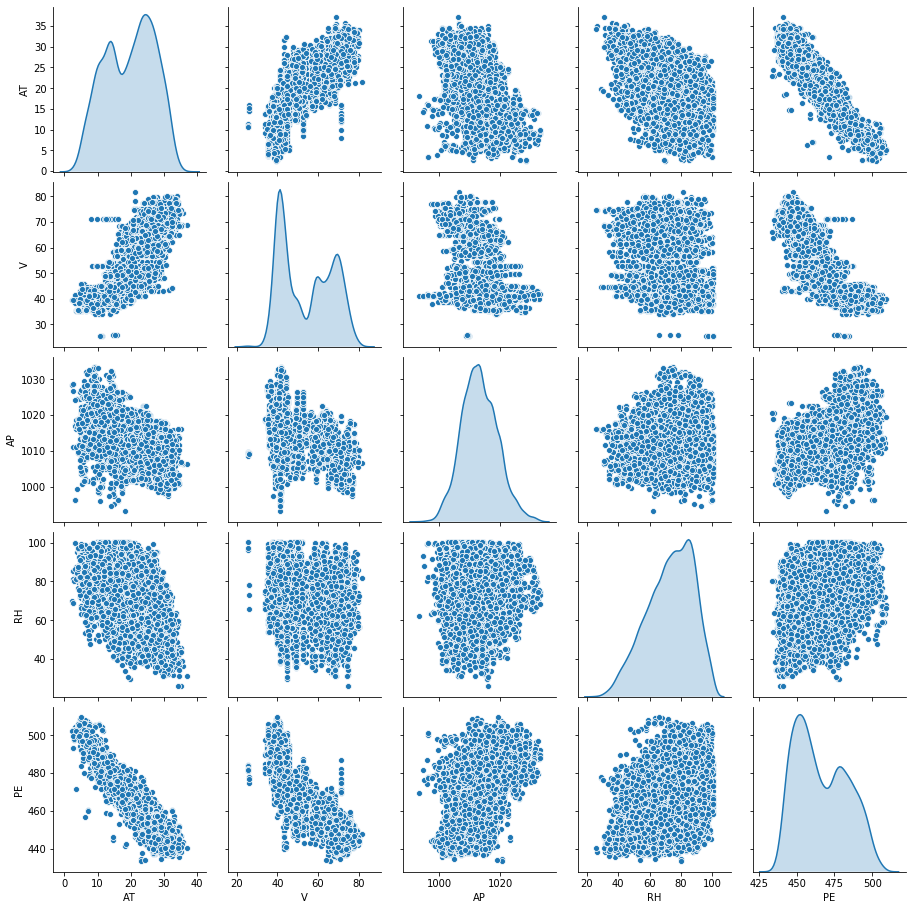

In [25]:
sns.pairplot(data, diag_kind = 'kde')

Multiple Clusters: As can be seen from above data, The fields AT, V and PE showing 2-3 peaks, it appears that this data is coming from 2-3 sources. Separating the data coming in from different data will help us to get clean models

Also

PE and AT are highly correlated

V and PE are also correlated

V and AT are also highly correlated


# Correlation Analysis

          AT         V        AP        RH        PE
AT  1.000000  0.842054 -0.514305 -0.541602 -0.946352
V   0.842054  1.000000 -0.415093 -0.306395 -0.867356
AP -0.514305 -0.415093  1.000000  0.115454  0.520058
RH -0.541602 -0.306395  0.115454  1.000000  0.387785
PE -0.946352 -0.867356  0.520058  0.387785  1.000000


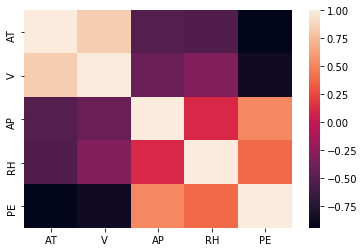

In [26]:
cor = data.corr()
print(cor)
sns.heatmap(cor)

# Clustering

In [27]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[['AT','V']])

In [28]:
data["clusterid"] = kmeans.labels_

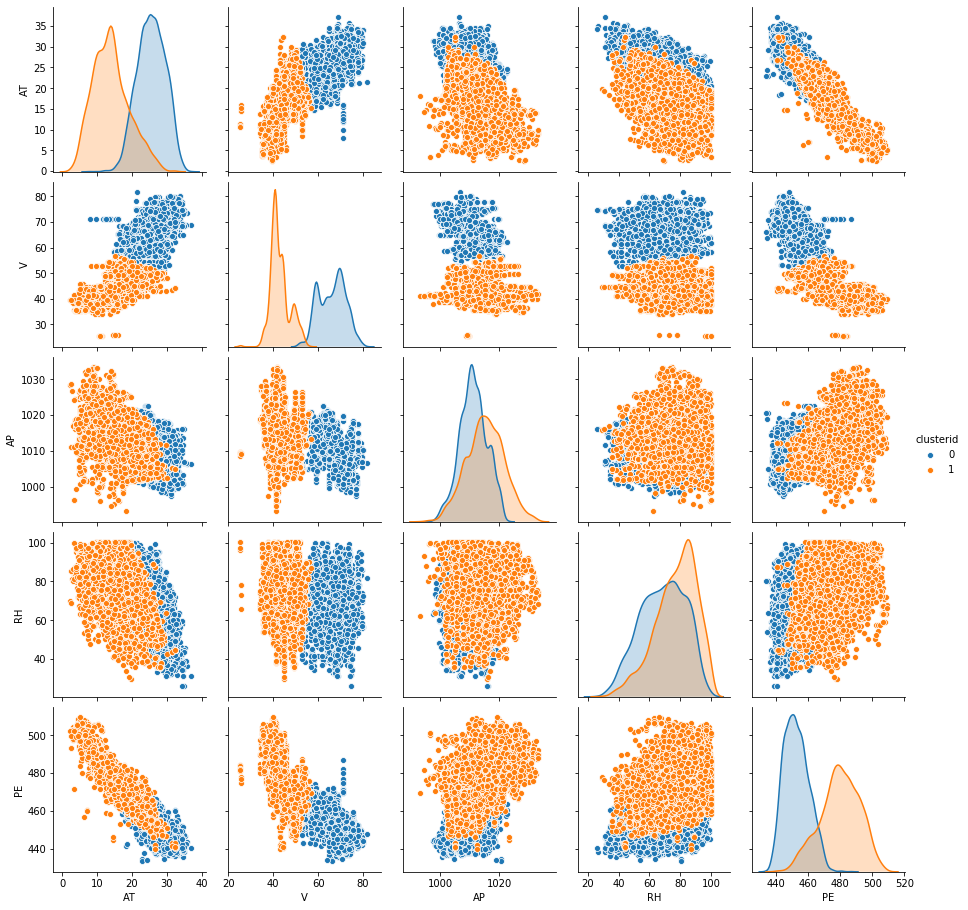

In [29]:
sns.pairplot(data, diag_kind = 'kde',hue = "clusterid")

As can be seen from above pairplot, the data is separated into clear clusters for the fields AT,V and PE

# Feature Engineering

In [30]:

poly = PolynomialFeatures(2)
data1 = poly.fit_transform(data[['AT','AP','V','RH']])
data2=pd.DataFrame(data1)
data2 = data2.merge(data, left_index=True,right_index=True)
data2.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,AT,V,AP,RH,PE,clusterid
0,1.0,29.07,1009.24,72.51,58.38,845.0649,29338.6068,2107.8657,1697.1066,1.018565e+06,...,58919.4312,5257.7001,4233.1338,3408.2244,29.07,72.51,1009.24,58.38,449.371855,0
1,1.0,32.38,1006.97,67.17,60.04,1048.4644,32605.6886,2174.9646,1944.0952,1.013989e+06,...,60458.4788,4511.8089,4032.8868,3604.8016,32.38,67.17,1006.97,60.04,450.861043,0
2,1.0,19.29,1007.94,67.71,63.71,372.1041,19443.1626,1306.1259,1228.9659,1.015943e+06,...,64215.8574,4584.6441,4313.8041,4058.9641,19.29,67.71,1007.94,63.71,460.894029,0
3,1.0,16.45,1016.64,41.48,45.21,270.6025,16723.7280,682.3460,743.7045,1.033557e+06,...,45962.2944,1720.5904,1875.3108,2043.9441,16.45,41.48,1016.64,45.21,467.577314,1
4,1.0,21.43,1013.94,46.97,61.25,459.2449,21728.7342,1006.5671,1312.5875,1.028074e+06,...,62103.8250,2206.1809,2876.9125,3751.5625,21.43,46.97,1013.94,61.25,469.805723,1


In [31]:
data2['clusterid'].value_counts()

1    4871
0    4697
Name: clusterid, dtype: int64

In [32]:
data_m0 = data2[data2['clusterid'] == 0]
data_m1 = data2[data2['clusterid'] == 1]

In [33]:
X0=data_m0.drop('PE',axis=1)
X1=data_m1.drop('PE',axis=1)
Y0=data_m0['PE']
Y1=data_m1['PE']

# Training

In [34]:
lrmodel0 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
lrmodel0.fit(X0,Y0)

lrmodel1 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
lrmodel1.fit(X1,Y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
lrmodel0.score(X0,Y0)

0.9924670721717549

In [36]:
lrmodel1.score(X1,Y1)

0.9972106301226694

# Getting output of Test Data

In [37]:
test = pd.read_csv('Test.csv')
test["clusterid"] = kmeans.predict(test[['AT','V']])
test1 = poly.fit_transform(test[['AT','AP','V','RH']])
test2=pd.DataFrame(test1)
test3 = test2.merge(test, left_index=True,right_index=True)
test0Data = test3[test3['clusterid'] == 0]
test1Data = test3[test3['clusterid'] == 1]


test0Data['PE'] = lrmodel0.predict(test0Data)
test1Data['PE'] = lrmodel1.predict(test1Data)
testfinal = test0Data.append(test1Data)
testfinal = testfinal.sort_index(axis = 0) 
predict = testfinal[['PE']]
predict.to_csv("submission9.csv", index=False)

D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
